In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable
import csv

# The bathymetry

Configure the extent 

In [2]:
bathymetry_extent = {
    "xmin" : 90, 
    "xmax" :  325.83,
    "ymin" :  -85,
    "ymax" : 85,
}

In [3]:
nami_extent = {
    "xmin" : 90,
    "xmax" : 325.83,
    "ymin" : -60,
    "ymax" : 70,
}

Bathymetry resolution

Read bathymetry

In [4]:
bathymetry_raw = np.fromfile(f'../../03_biobio2010/data/bathymetry3min',dtype='float64')
bathymetry_shape = np.asarray(bathymetry_raw[:2], dtype=int)    
bathymetry_raw = bathymetry_raw[2:]
bathymetry_raw = bathymetry_raw.reshape(bathymetry_shape)

In [5]:
bathymetry_raw.shape

(3400, 4717)

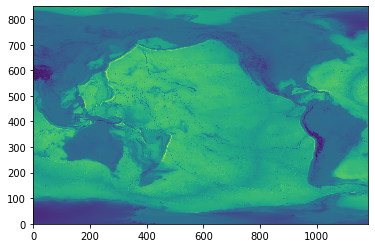

In [6]:
plt.pcolormesh(bathymetry_raw[::4, ::4])

Trim parts of the bathymetry not in the domain of Nami

In [7]:
ds_original = 3

In [8]:
lat_start_index = int((nami_extent["ymin"] - bathymetry_extent["ymin"])/(ds_original/60))
lat_end_index = bathymetry_shape[0] - int((bathymetry_extent["ymax"] - nami_extent["ymax"])/(ds_original/60))
lon_start_index = int((nami_extent["xmin"] - bathymetry_extent["xmin"])/(ds_original/60))
lon_end_index = bathymetry_shape[1] - int((bathymetry_extent["xmax"] - nami_extent["xmax"])/(ds_original/60))
print(f"lat_start_index={lat_start_index}")
print(f"lat_end_index={lat_end_index}")
print(f"lon_start_index={lon_start_index }")
print(f"lon_end_index={ lon_end_index }")

lat_start_index=500
lat_end_index=3100
lon_start_index=0
lon_end_index=4717


In [9]:
skip = 1
bathymetry = bathymetry_raw[lat_start_index:lat_end_index,lon_start_index:lon_end_index]
bathymetry = bathymetry[::skip, ::skip][:,:-1]
nlat, nlon = bathymetry.shape
print(f"nlat = {nlat}, nlon = {nlon}")

nlat = 2600, nlon = 4716


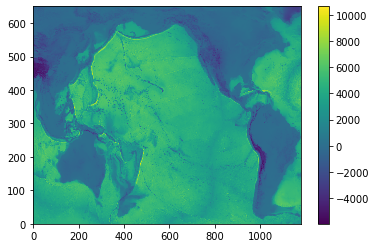

In [10]:
plt.pcolormesh(bathymetry[::4, ::4])
plt.colorbar()

# Read max heights and arrival

In [11]:
def read_large_nami_csv(path):
    reader = csv.reader(open(path))

    for row in reader:
        continue

    return np.array(row, dtype=float)

In [12]:
nami_folder = "../nami"

In [13]:
nlat

2600

In [14]:
hmax_unmasked = read_large_nami_csv(f"{nami_folder}/tlab2D.csv").reshape((nlat, -1))

In [15]:
harr_unmasked = read_large_nami_csv(f"{nami_folder}/tlab2D (1).csv").reshape((nlat,-1))

harr = np.ma.masked_where(bathymetry<500, harr_unmasked)
hmax = np.ma.masked_where(bathymetry<10, hmax_unmasked)

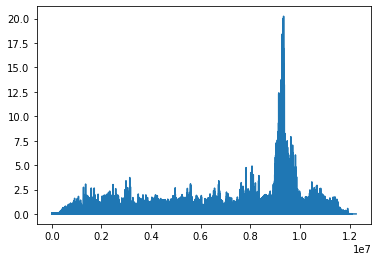

In [16]:
plt.plot(hmax_unmasked.ravel())

In [17]:
np.percentile(hmax_unmasked.ravel(), 90)

0.22182858288288115

In [18]:
x = np.linspace(nami_extent["xmin"], nami_extent["xmax"], nlon)
y = np.linspace(nami_extent["ymin"], nami_extent["ymax"], nlat)
x, y = np.meshgrid(x, y)

Pois locations

In [19]:
[21418,32411,51407,55012]

[21418, 32411, 51407, 55012]

In [20]:
pois={
    21414: [178.219,48.968],
    21419: [155.717,44.435],
    21401: [152.583,42.617],
    21418: [148.645,38.727],
    21413: [152.132,30.533],
    52403: [145.52,4.02],
    52406: [164.977,-5.307],
    55012: [158.453,-15.664],
    51425: [183.68,-9.517],
    51407: [203.455,19.57],
    46404: [231.267,45.853],
    46407: [231.168,42.682],
    46411: [232.933,39.333],
    46412: [239.437,32.492],
    43412: [253.03300000000002,16.045],
    43413: [259.91700000000003,11.012],
    32411: [269.12,4.953],
    32412: [273.626,-17.984],
    32413: [266.483,-7.406],
    32401: [286.579,-20.474],
}
darts_ids = [21413, 32412, 43412, 46404, 46407, 46411, 46412, 51425, 52403]# [21418,32411,51407,55012]
# darts_ids = [21413, 32412, 43412, 46404, 46407, 46411, 46412, 51425, 52403, 21418,32411,51407,55012]

In [21]:
dart_locations = np.array(list(pois.values()))

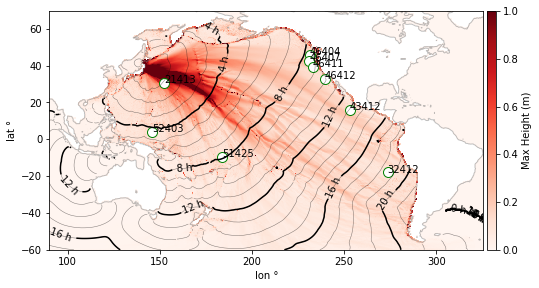

In [22]:
s = 10 #skip size


f = plt.figure(figsize=(8,6))
ax1 = f.add_subplot(111)

p = ax1.pcolormesh(x[::s,::s],y[::s,::s],hmax[::s,::s],vmax=1,vmin=0, cmap=plt.cm.Reds, shading="nearest")
divider = make_axes_locatable(ax1)

for  dart in darts_ids:
    
    [lon, lat] = pois[dart]
    ax1.scatter([lon],[lat],color='white',edgecolor='green',marker='o', s=100)
    ax1.annotate('%s'%dart, [lon+0.1,lat])
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = f.colorbar(p,cax)
cbar.set_label('Max Height (m)')

ax1.contour(x[::s,::s],y[::s,::s], bathymetry[::s,::s], [10], linewidths=1, alpha=0.5, colors='grey')
CS = ax1.contour(x[::s,::s],y[::s,::s],harr[::s,::s]/60/60,np.arange(0,24,4),colors='k')
ax1.clabel(CS, inline=1, fontsize=10, fmt='%i h')
ax1.contour(x[::s,::s],y[::s,::s],harr[::s,::s]/60/60,
            np.arange(0,24,1),colors='k', linewidths=0.5, alpha=0.5)

ax1.set_aspect(1)
ax1.set_xlabel('lon °')
ax1.set_ylabel('lat °')
f.savefig('energy2010.png',dpi=300,bbox_inches='tight')

In [23]:
x.min(),x.max()

(90.0, 325.83)

# Time series

Read Nami time series

In [24]:
nami = pd.read_json(f"{nami_folder}/pois")

Check that the pixels make sense

In [25]:
nami

,21401,21413,21414,21418,21419,32401,32411,32412,32413,43412,43413,46404,46407,46411,46412,51407,51425,52403,52406,55012
location,"[152.583, 42.617]","[152.132, 30.533]","[178.219, 48.968]","[148.645, 38.727]","[155.717, 44.435]","[286.579, -20.474]","[269.12, 4.953]","[273.626, -17.984]","[266.483, -7.406]","[253.03300000000002, 16.045]","[259.91700000000003, 11.012]","[231.267, 45.853]","[231.168, 42.682]","[232.933, 39.333]","[239.437, 32.492]","[203.455, 19.57]","[183.68, -9.517]","[145.52, 4.02]","[164.977, -5.307]","[158.453, -15.664]"
pixel,"[1251, 2052]","[1242, 1810]","[1764, 2179]","[1173, 1974]","[1314, 2088]","[3930, 790]","[3581, 1299]","[3671, 840]","[3528, 1051]","[3260, 1520]","[3397, 1420]","[2824, 2116]","[2822, 2053]","[2858, 1986]","[2988, 1849]","[2268, 1591]","[1873, 1009]","[1110, 1280]","[1499, 1093]","[1369, 886]"
surface,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
time,"[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989...","[2.936631988622083, 5.873263977244166, 8.80989..."
shallowCorrectionFactor,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [26]:
ds = 3

(152.583, 152.55), (42.617, 42.599999999999994)
(152.132, 152.1), (30.533, 30.5)
(178.219, 178.2), (48.968, 48.95)
(148.645, 148.65), (38.727, 38.7)
(155.717, 155.7), (44.435, 44.400000000000006)
(286.579, 286.5), (-20.474, -20.5)
(269.12, 269.05), (4.953, 4.950000000000003)
(273.626, 273.55), (-17.984, -18.0)
(266.483, 266.4), (-7.406, -7.450000000000003)
(253.03300000000002, 253.0), (16.045, 16.0)
(259.91700000000003, 259.85), (11.012, 11.0)
(231.267, 231.2), (45.853, 45.8)
(231.168, 231.1), (42.682, 42.650000000000006)
(232.933, 232.9), (39.333, 39.3)
(239.437, 239.4), (32.492, 32.45)
(203.455, 203.4), (19.57, 19.549999999999997)
(183.68, 183.65), (-9.517, -9.549999999999997)
(145.52, 145.5), (4.02, 4.0)
(164.977, 164.95), (-5.307, -5.350000000000001)
(158.453, 158.45), (-15.664, -15.700000000000003)


Text(0.5, 1.0, 'pixel vs real')

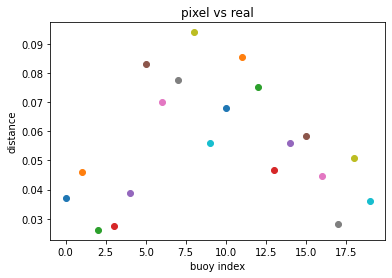

In [27]:
for i, buoy in enumerate(nami.keys()):
    buoy_lon, buoy_lat = nami[buoy]["location"]
    buoy_lon_pixel, buoy_lat_pixel = nami[buoy]["pixel"]
    lon_pixel = buoy_lon_pixel * ds*skip/60 + nami_extent["xmin"]
    lat_pixel = buoy_lat_pixel * ds*skip/60 + nami_extent["ymin"]  
    p0 = np.array([buoy_lon, buoy_lat])
    p1 = np.array([lon_pixel, lat_pixel])
    distance = np.linalg.norm(p0-p1, 2)
    plt.scatter([i], [distance])

    print(f"{buoy_lon, lon_pixel}, {buoy_lat, lat_pixel}")
plt.xlabel("buoy index")
plt.ylabel("distance")
plt.title("pixel vs real")


Read Easywave time series

In [28]:
ls ../easywave

clean.sh                eWave.2D.30300.ssh  eWave.2D.61500.ssh
compare_easywave.ipynb  eWave.2D.30600.ssh  eWave.2D.61800.ssh
easywave.log            eWave.2D.30900.ssh  eWave.2D.62100.ssh
eWave.2D.00000.ssh      eWave.2D.31200.ssh  eWave.2D.62400.ssh
eWave.2D.00300.ssh      eWave.2D.31500.ssh  eWave.2D.62700.ssh
eWave.2D.00600.ssh      eWave.2D.31800.ssh  eWave.2D.63000.ssh
eWave.2D.00900.ssh      eWave.2D.32100.ssh  eWave.2D.63300.ssh
eWave.2D.01200.ssh      eWave.2D.32400.ssh  eWave.2D.63600.ssh
eWave.2D.01500.ssh      eWave.2D.32700.ssh  eWave.2D.63900.ssh
eWave.2D.01800.ssh      eWave.2D.33000.ssh  eWave.2D.64200.ssh
eWave.2D.02100.ssh      eWave.2D.33300.ssh  eWave.2D.64500.ssh
eWave.2D.02400.ssh      eWave.2D.33600.ssh  eWave.2D.64800.ssh
eWave.2D.02700.ssh      eWave.2D.33900.ssh  eWave.2D.65100.ssh
eWave.2D.03000.ssh      eWave.2D.34200.ssh  eWave.2D.65400.ssh
eWave.2D.03300.ssh      eWave.2D.34500.ssh  eWave.2D.65700.ssh
eWave.2D.03600.ssh      eWave.2D.34800.ssh  eWave.2D.66

In [29]:
ewave = pd.read_csv('../easywave/eWave.poi.ssh', delim_whitespace=True)

Read DART buoys time series

In [30]:
darts = {}
for dart in darts_ids:
    darts[dart] = np.loadtxt('../data/tsunamiDART{}'.format(dart))

In [31]:
starts = {
    21418: 0,
    21413:60,
    52403: 260,
    55012: 550,
    51425: 450,
    51407: 800,
    46404: 500,
    46407: 500,
    46411: 500,
    46412: 550,
    43412: 750,
    32412: 1100,
}

In [32]:
group1 = [32412, 43412, 46412]
group2 = [46411, 46407, 46404]
group3 = [51425, 52403, 21413]
orderedBuoys = [32412, 46411, 51425, 43412, 46407, 52403, 46412, 46404, 21413]
orderedBuoys = [32412, 43412, 46412, 46411, 46407, 51425, 46404, 52403, 21413 ]

In [33]:
yranges = {
    46411: [-0.05, 0.1],
    46404: [-0.1,0.1]
}

GeoClaw timeseries

In [34]:
from clawpack.pyclaw.gauges import GaugeSolution
geoclaw = {
    gauge_id : GaugeSolution(gauge_id=gauge_id, path='../geoclaw/_output')
    for gauge_id in orderedBuoys
    
}

Main figure for the paper

In [35]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 6}

matplotlib.rc('font', **font)

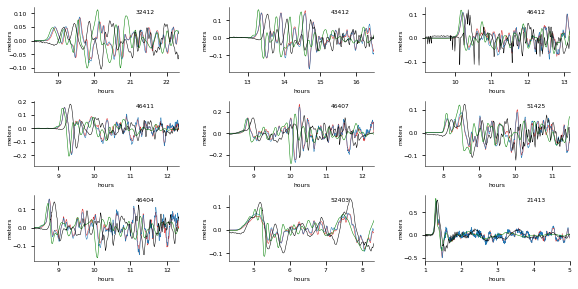

In [37]:
f = plt.figure(figsize=(12 / 1.5, 6 / 1.5))
for i, dart_number in enumerate(orderedBuoys):
    ax = f.add_subplot(3, 3, i + 1)

    ax.plot(
        ewave["Minute"] / 60.0,
        ewave[str(dart_number)],
        label="easywave",
        color="#d62728",
        linewidth=0.5,
    )
    ax.plot(
        np.array(nami[dart_number].time) / 60 / 60,
        nami[dart_number].surface,
        label="nami",
        linewidth=0.5,
    )
    ax.plot(
        geoclaw[dart_number].t / 60 / 60,
        geoclaw[dart_number].q[3, :],
        color="g",
        linewidth=0.5,
        label="geoclaw",
    )    
    ax.plot(
        darts[dart_number][:, 0] * 24,
        darts[dart_number][:, 1],
        label="dart buoy",
        color="k",
        linewidth=0.5,
    )


    xmin = min(starts[dart_number] / 60, 20)
    xmax = min(starts[dart_number] / 60 + 4, 25)
    ax.set_xlim(xmin, xmax)
    ax.annotate("%s" % dart_number, [0.7, 0.9], xycoords="axes fraction")
    ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_linewidth(0.5)

    ax.spines["bottom"].set_linewidth(0.5)
    xticks = np.arange(np.ceil(xmin), np.ceil(xmax + 0.5), 1, dtype=int)
    ax.set_xticks(xticks)
#     if dart_number in group1:
#         ax.set_ylim(-0.15, 0.25)
#         ax.set_yticks(np.arange(-0.1, 0.2, 0.1))
#     elif dart_number in group2:
#         ax.set_ylim(-0.05, 0.07)
#         ax.set_yticks(np.arange(-0.05, 0.051, 0.05))

    ax.set_xlabel("hours")
    ax.set_ylabel("meters")


f.tight_layout()
f.subplots_adjust(wspace=0.35)
f.savefig("timeseries2011.png", dpi=300, bbox_inches="tight")

<img src="./timeseries2011.png"></img>

* Easywave y nami son iguales entre sí
* Todos llegan antes que las mediciones
* Geoclaw llega siempre antes que los demás

Fact: Ya hay evidencia de que a medida que se propaga se desfasa por efectos de incompresibilidad y elasticidad del fondo


¿Crece la distancia cuando nos alejamos del origen del terrmoto?

# Peak arrival comparison

In [57]:
edited_starts = {
    32412: 19,
    43412: 13,
    46412: 10,
    46411: 9,
    46407: 8,
    51425: 8, 
    46404: 8,
    52403: 4, 
    21413: 1
}
ends = {
    32412: 19.5,
    43412: 13.5,
    46412: 11,
    46411: 11,
    46407: 9.5,
    51425: 9, 
    46404: 9.5,
    52403: 6,     
    21413: 2
}

In [58]:
def get_max_and_max_loc(t, y, time_to_hours_factor, start=0, end=4):
    t = np.array(t) * time_to_hours_factor
    y = np.array(y)
    is_in_interval = (t > start) * (t < end)
    y_filtered = y[is_in_interval]
    t_filtered = t[is_in_interval]

    if len(t_filtered) == 0:
        return t[-1], y[-1]
    return t_filtered[np.argmax(y_filtered)], np.max(y_filtered)


# def get_max_and_max_loc(t, y, time_to_hours_factor, start=0, end=4):
#     t = np.array(t) * time_to_hours_factor
#     y = np.array(y)
#     is_in_interval = (t > start) * (t < end)
#     y_filtered = y[is_in_interval]
#     t_filtered = t[is_in_interval]

#     index = np.where(y_filtered>0.01)[0][0]
#     return t_filtered[index], y_filtered[index]



In [59]:
poisid = [buoy for buoy in orderedBuoys]
peaks = {
    "nami": {
        dart_number: get_max_and_max_loc(
            nami[dart_number].time,
            nami[dart_number].surface,
            time_to_hours_factor=1 / 60 / 60,
            start=edited_starts[dart_number],
            end=ends[dart_number]
        )
        for dart_number in poisid
    },
    "easywave": {
        dart_number: get_max_and_max_loc(
            ewave["Minute"], ewave[str(dart_number)], time_to_hours_factor=1 / 60,
            start=edited_starts[dart_number],
            end=ends[dart_number]
        )
        for dart_number in poisid
    },
    "geoclaw": {
        dart_number: get_max_and_max_loc(
            geoclaw[dart_number].t, geoclaw[dart_number].q[3, :], time_to_hours_factor=1 / 60 / 60,
            start=edited_starts[dart_number],
            end=ends[dart_number]
        )
        for dart_number in poisid
    },
    "measurements": {
        dart_number: get_max_and_max_loc(
            darts[dart_number][:, 0], darts[dart_number][:, 1], time_to_hours_factor=24,
            start=edited_starts[dart_number],
            end=ends[dart_number]
        )
        for dart_number in poisid
    },
}

In [60]:
times = {
    model: np.array([
        peaks[model][dart_number][0]
        for dart_number in poisid
    ])
    for model in peaks 
}

differences = {
    model: np.array([
        peaks[model][dart_number][0] - peaks["measurements"][dart_number][0]
        for dart_number in poisid
    ])
    for model in peaks if model != "measurements"
}

In [61]:
from pprint import pprint
pprint(times)

{'easywave': array([19.23333333, 13.38333333, 10.21666667,  9.175     ,  8.84166667,
        8.51666667,  8.75833333,  5.075     ,  1.30833333]),
 'geoclaw': array([19.14112778, 13.29861944, 10.16434722,  9.11778333,  8.81477222,
        8.45526389,  8.722325  ,  5.18745833,  1.29892639]),
 'measurements': array([19.44721904, 13.49809967, 10.36149102,  9.34250521,  8.9932874 ,
        8.59279989,  8.89481062,  5.17867095,  1.34168123]),
 'nami': array([19.21699344, 13.38288456, 10.21458493,  9.17860643,  8.83518363,
        8.51541704,  8.75605771,  5.06732164,  1.31006416])}


In [62]:
order_by_earliest_index = np.argsort(times["measurements"])

In [63]:
poisid

[32412, 43412, 46412, 46411, 46407, 51425, 46404, 52403, 21413]

In [64]:
buoys_sorted_by_earliest = [poisid[index] for index in order_by_earliest_index]

Increase font size to improve readability on screens

(array([0.6, 1.6, 2.6, 3.6, 4.6, 5.6, 6.6, 7.6, 8.6]),
 <a list of 9 Text major ticklabel objects>)

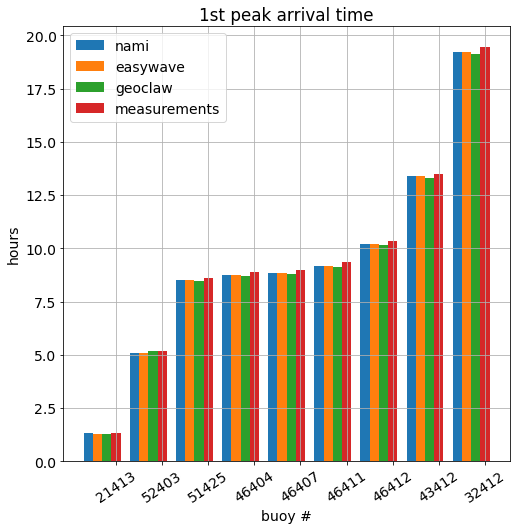

In [65]:
font = {'size'   : 14}
matplotlib.rc('font', **font)

plt.figure(figsize=(8,8))
for i, model in enumerate(times):
    plt.bar(
        np.arange(len(poisid)) + 0.2 * i,
        times[model][order_by_earliest_index],
        width=0.2,
        label=model,
        tick_label=buoys_sorted_by_earliest
    )

plt.xlabel("buoy #")
plt.ylabel("hours")
plt.title("1st peak arrival time")
plt.legend()
plt.grid(which="both")
plt.xticks(rotation=34)

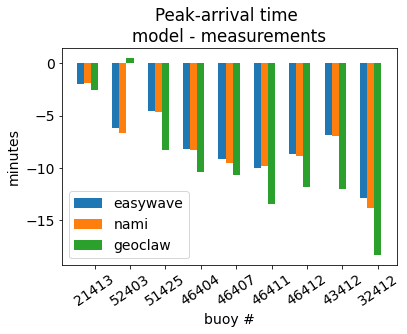

In [66]:
for i, model in enumerate(["easywave", "nami", "geoclaw"]):
    if model == "":
        continue
    plt.bar(
        np.arange(len(poisid)) + 0.2 * i, 
        differences[model][order_by_earliest_index]*60,
        width=0.2,
        label=model,
        tick_label=buoys_sorted_by_earliest,
    )

plt.ylabel("minutes")
plt.xlabel("buoy #")
plt.title("Peak-arrival time \nmodel - measurements")
plt.xticks(rotation=34)
plt.legend()

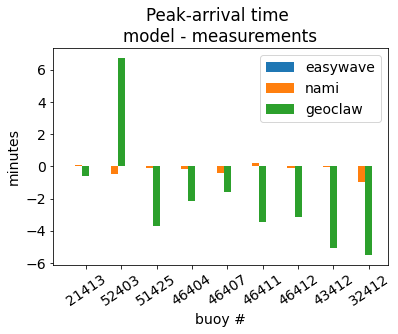

In [76]:
for i, model in enumerate(["easywave", "nami", "geoclaw"]):
    plt.bar(
        np.arange(len(poisid)) + 0.2 * i, 
        differences[model][order_by_earliest_index]*60 - differences["easywave"][order_by_earliest_index]*60,
        width=0.2,
        label=model,
        tick_label=buoys_sorted_by_earliest,
    )

plt.ylabel("minutes")
plt.xlabel("buoy #")
plt.title("Peak-arrival time \nmodel - measurements")
plt.xticks(rotation=34)
plt.legend()

Inspect the peaks location on the time series

In [67]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [68]:
colors = [
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    "k"
]

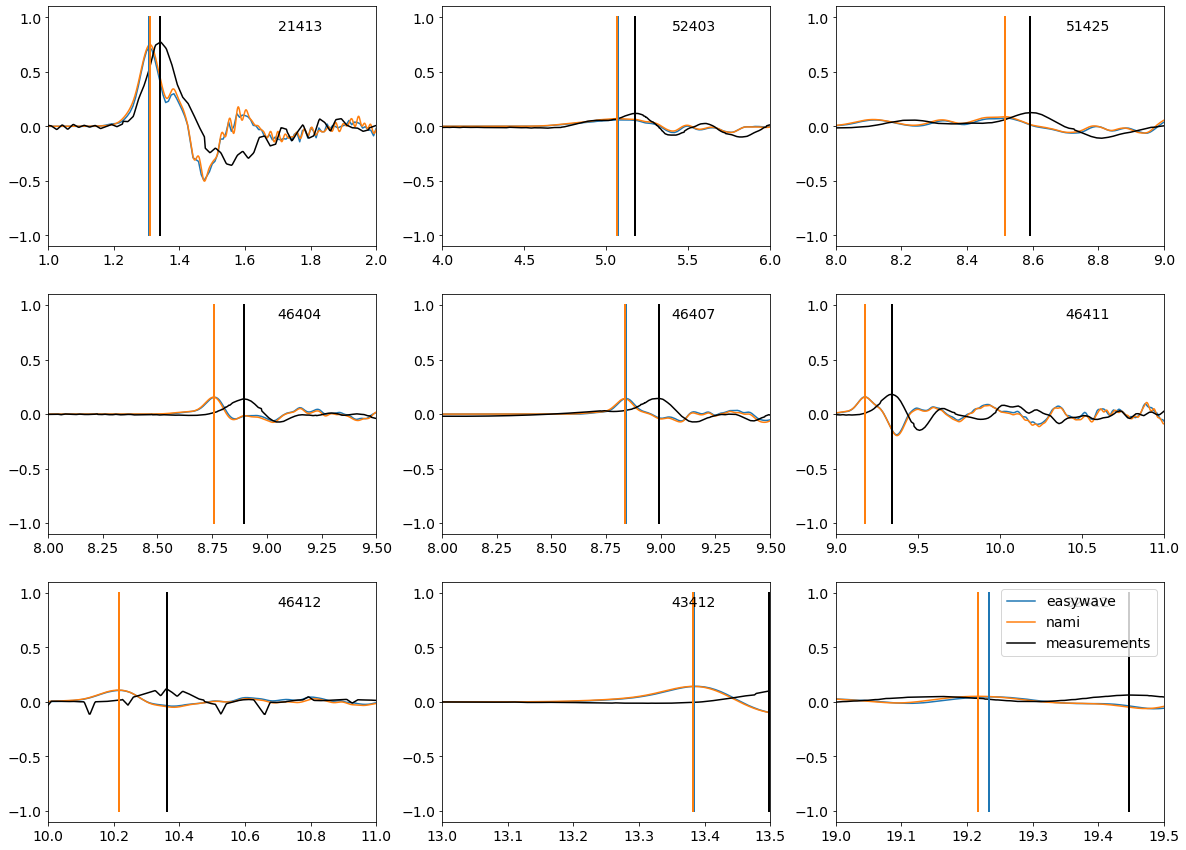

In [69]:
f = plt.figure(figsize=(20, 15))
for i, dart_number in enumerate(np.array(poisid)[order_by_earliest_index]):
    ax = f.add_subplot(3, 3, i + 1)

    ax.plot(
        ewave["Minute"] / 60.0,
        ewave[str(dart_number)],
        label="easywave",
        color=colors[0],
        linewidth=1.5,
    )
    ax.plot(
        np.array(nami[dart_number].time) / 60 / 60,
        nami[dart_number].surface,
        label="nami",
        color=colors[1],
        linewidth=1.5,
    )
#     ax.plot(
#         geoclaw[dart_number].t / 60 / 60,
#         geoclaw[dart_number].q[3, :],
#         linewidth=1.5,
#         color=colors[2],
#         label="geoclaw",
#     )
    ax.plot(
        darts[dart_number][:, 0] * 24,
        darts[dart_number][:, 1],
        label="measurements",
        color=colors[3],
        linewidth=1.5,
    )

    ax.set_xlim(edited_starts[dart_number], ends[dart_number])
    for nmodel, model in enumerate([
        "easywave", 
        "nami",
        "geoclaw", 
        "measurements"
    ]):
        if model in ["geoclaw"]:
            continue
        ax.plot(
            [times[model][order_by_earliest_index[i]], times[model][order_by_earliest_index[i]]],
            [-1, 1],
            color=colors[nmodel],
            linewidth=2,
        )

#     if dart_number in group1:
#         ax.set_ylim(-0.15, 0.25)
#         ax.set_yticks(np.arange(-0.1, 0.2, 0.1))
#     elif dart_number in group2:
#         ax.set_ylim(-0.05, 0.07)
#         ax.set_yticks(np.arange(-0.05, 0.051, 0.05))
#     else:
#         ax.set_ylim(-0.15, 0.15)
    #         ax.set_yticks(np.arange(-0.05, 0.051, 0.05))
    ax.annotate("%s" % dart_number, [0.7, 0.9], xycoords="axes fraction")

plt.legend()

# Relation between bathymetry and phase err

Also plot it to compare arrival times against the bathymetry

In [70]:
from clawpack.visclaw import colormaps, geoplot

Text(0, 0.5, 'lat °')

2021-05-21 14:03:19,682 WARNING CLAW: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


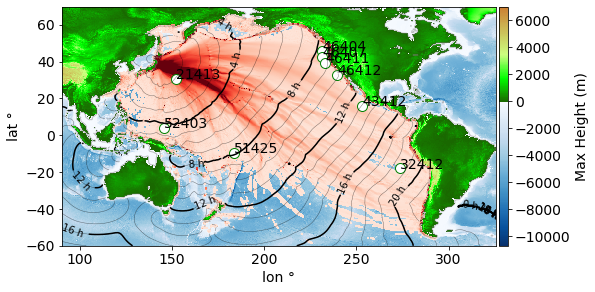

In [71]:
topography = - bathymetry
land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                     0.25:[0.0,1.0,0.0],
                                      0.5:[0.8,1.0,0.5],
                                      1.0:[0.8,0.5,0.2]})
sea_cmap = plt.get_cmap('Blues_r')

cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap), 
                                     data_limits=[topography.min(), topography.max()],
                                     data_break=0)
f = plt.figure(figsize=(8,6))
ax1 = f.add_subplot(111)

p = ax1.pcolormesh(x[::s,::s],y[::s,::s],topography[::s,::s],cmap=cmap, norm=norm, shading="nearest")

p2 = ax1.pcolormesh(x[::s,::s],y[::s,::s],np.ma.masked_where(hmax[::s,::s]<=0.1, hmax[::s,::s]),vmax=1,vmin=0, cmap=plt.cm.Reds, shading="nearest")



divider = make_axes_locatable(ax1)

for  dart in darts_ids:
    [lon, lat] = pois[dart]
    ax1.scatter([lon],[lat],color='white',edgecolor='green',marker='o', s=100)
    ax1.annotate('%s'%dart, [lon+0.1,lat])
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = f.colorbar(p,cax)
cbar.set_label('Max Height (m)')

ax1.contour(x[::s,::s],y[::s,::s], bathymetry[::s,::s], [10], linewidths=1, alpha=0.5, colors='grey')
CS = ax1.contour(x[::s,::s],y[::s,::s],harr[::s,::s]/60/60,np.arange(0,24,4),colors='k')
ax1.clabel(CS, inline=1, fontsize=10, fmt='%i h')
ax1.contour(x[::s,::s],y[::s,::s],harr[::s,::s]/60/60,
            np.arange(0,24,1),colors='k', linewidths=0.5, alpha=0.5)

ax1.set_aspect(1)
ax1.set_xlabel('lon °')
ax1.set_ylabel('lat °')

Ubicaciones y batimetría de cada punto

In [72]:
dart = 21414
buoys_to_compare_bathymetry = [poisid[index] for index in order_by_earliest_index]
bathymetry_to_compare = []
for dart in buoys_to_compare_bathymetry:
    x_index = int((pois[dart][0]-x.min())/(ds*skip/60)+0.5)
    y_index = int((pois[dart][1]-y.min())/(ds*skip/60)+0.5)
    poi_bathymetry = bathymetry[y_index, x_index]
    bathymetry_to_compare.append(poi_bathymetry)
    print(dart,poi_bathymetry)

21413 5865.0
52403 4482.0
51425 4771.0
46404 2769.0
46407 3347.0
46411 4331.0
46412 3798.0
43412 3641.0
32412 4394.0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

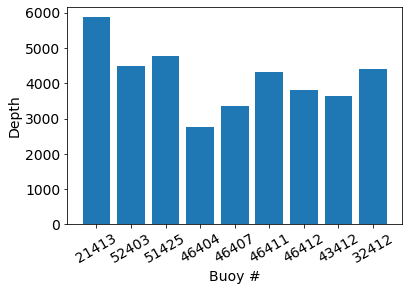

In [73]:
plt.bar(
    np.arange(len(buoys_to_compare_bathymetry)),
    bathymetry_to_compare,
#     width=0.2,
#     label=model,
    tick_label=buoys_to_compare_bathymetry,
)
plt.xlabel("Buoy #")
plt.ylabel("Depth")
plt.xticks(rotation=30)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

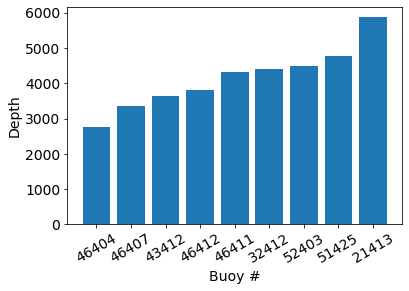

In [74]:
increasing_bathymetry = np.sort(bathymetry_to_compare)
increasing_bathymetry_order = np.argsort(bathymetry_to_compare)
plt.bar(np.arange(len(buoys_to_compare_bathymetry)), increasing_bathymetry, tick_label=[buoys_to_compare_bathymetry[i] for i in increasing_bathymetry_order])
plt.xlabel("Buoy #")
plt.ylabel("Depth")
plt.xticks(rotation=30)

2021-05-21 14:03:41,817 WARNING CLAW: No handles with labels found to put in legend.


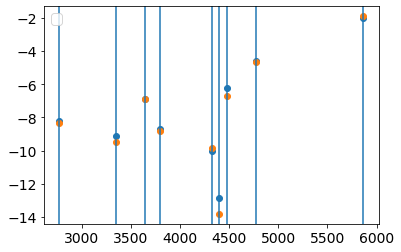

In [75]:
for i, model in enumerate(["easywave", "nami", "geoclaw"]):
    if model == "geoclaw":
        continue
    plt.plot(bathymetry_to_compare, differences[model][order_by_earliest_index]*60, "o")
plt.legend()
for b in bathymetry_to_compare:
    plt.axvline(x=b)